In [1]:
import os 
import hashlib
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

2024-09-03 15:45:32.934350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 15:45:33.135880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-03 15:45:33.135900: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-03 15:45:33.921780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

## Load Data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [2]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [3]:
"""Loadning training split"""
start_window = 100
end_window = 500
data_dir = "../data/malab_05282024/npz/"
assert os.path.exists(f"{data_dir}/0528_X_train_0_770.npy"), "File does not exist "

x_train_path = os.path.join(data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(data_dir, f'0528_y_train_0_770.npy')

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

X_train_val = X_train_val[:,start_window*2:end_window*2]
y_train_val = one_hot_encode(y_train_val)

print("Train Data Set:")
print("\tX Path        :", x_train_path)
print("\ty Path        :", y_train_path)
print("\tSize          :", len(X_train_val))
print("\tSample Shape  :", X_train_val[0].shape)
print("\tMean          :", X_train_val.mean())
print("\tStd. Dev.     :", X_train_val.std())

assert len(X_train_val[0]) == (end_window-start_window)*2, "ERROR: Specified window does not match loaded dataset shape"

Train Data Set:
	X Path        : ../data/malab_05282024/npz/0528_X_train_0_770.npy
	y Path        : ../data/malab_05282024/npz/0528_y_train_0_770.npy
	Size          : 900000
	Sample Shape  : (800,)
	Mean          : 42.473523191666665
	Std. Dev.     : 842.7678298796162


In [4]:
"""Loading testing split"""
start_window = 100
end_window = 500
data_dir = "../data/malab_05282024/npz/"
assert os.path.exists(f"{data_dir}/X_test_0_770.npy"), "File does not exist "

x_test_path = os.path.join(data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(data_dir, f'0528_y_test_0_770.npy')

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

X_test = X_test[:,start_window*2:end_window*2]
y_test = one_hot_encode(y_test)

print("Test Data Set:")
print("\tX Path        :", x_test_path)
print("\ty Path        :", y_test_path)
print("\tSize         :", len(X_test))
print("\tSample Shape :", X_test[0].shape)
print("\tSample Shape :", X_test.mean())
print("\tStd. Dev.    :", X_test.std())

assert len(X_test[0]) == (end_window-start_window)*2, "ERROR: Specified window does not match loaded dataset shape"

Test Data Set:
	X Path        : ../data/malab_05282024/npz/0528_X_test_0_770.npy
	y Path        : ../data/malab_05282024/npz/0528_y_test_0_770.npy
	Size         : 100000
	Sample Shape : (800,)
	Sample Shape : 42.5891728375
	Std. Dev.    : 844.2103580495092


## Multi-layer Model 
Or the initial "big" model 

<!-- ![Multi-layer model](../images/multi_layer_model.png) -->
<img src="../images/multi_layer_model.png" alt="alt text" width="75%">

In [5]:
"""hyperparameters"""
init_learning_rate = 1e-1
validation_split = 0
batch_size = 8192
epochs = 500
checkpoint_filename = "multi-layer.h5"
input_shape = (len(X_train_val[0]),)

In [6]:
def get_model():
    sr = int((end_window-start_window)*2)
    hn = sr * 2

    model = Sequential()
    model.add(Dense(int(hn/8), activation='relu', input_shape=(sr,)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='relu'))
    return model

model = get_model()
print(model.summary())
assert model.count_params() == 161402, 'Error. Total parameters has changed.'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               160200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 161,402
Trainable params: 161,002
Non-trainable params: 400
_________________________________________________________________
None


2024-09-03 15:47:00.326908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-03 15:47:00.327124: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-03 15:47:00.327162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-09-03 15:47:00.327490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Scan Learning Rate 

In [7]:
learning_rates = [init_learning_rate/(10**idx) for idx in range(8)]
learning_rates

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1.0000000000000001e-07, 1e-08]

In [8]:
all_accuracy = list()
all_e_accuracy = list() 
all_g_accuracy = list()
all_fidelity = list()

for learning_rate in learning_rates:
    #########################
    # 1. init callbacks
    #########################
    callbacks = [
        ModelCheckpoint(
            checkpoint_filename,
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            save_freq="epoch",
        ),
        EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        ),
    ]

    #########################
    # 2. declare model 
    #########################
    opt = Adam(learning_rate=learning_rate)
    model = get_model()
    model.compile(
        optimizer=opt, 
        loss=CategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )

    #########################
    # 3. train 
    #########################
    history = model.fit(
        X_train_val, 
        y_train_val, 
        batch_size=batch_size,
        epochs=epochs, 
        validation_split=0.05, 
        shuffle=True, 
        callbacks=callbacks,
        verbose=0,
    )

    #########################
    # 4. compute fidelity 
    #########################
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    # print("Keras  Accuracy: {}".format(test_acc))
    all_accuracy.append(test_acc)
    
    # get ground and excited indices 
    e_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]
    g_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]

    # separate ground and excited samples 
    Xe_test = X_test[e_indices]
    ye_test = np.argmax(y_test, axis=1)[e_indices]

    Xg_test = X_test[g_indices]
    yg_test = np.argmax(y_test, axis=1)[g_indices]

    # compute total correct for excited state 
    ye_pred = model.predict(Xe_test)
    e_accuracy = accuracy_score(ye_test, np.argmax(ye_pred, axis=1))

    total_correct = (ye_test==np.argmax(ye_pred, axis=1)).astype(np.int8).sum()
    total_incorrect = (ye_test!=np.argmax(ye_pred, axis=1)).astype(np.int8).sum()

    # print("Total correct:", total_correct)
    # print("Total incorrect:", total_incorrect)
    # print("Total samples:", len(Xe_test) )
    # print("Keras Excited Accuracy: {}".format(e_accuracy))

    # compute total correct for ground state 
    yg_pred = model.predict(Xg_test)
    g_accuracy = accuracy_score(yg_test, np.argmax(yg_pred, axis=1))

    total_correct = (yg_test==np.argmax(yg_pred, axis=1)).astype(np.int8).sum()
    total_incorrect = (yg_test!=np.argmax(yg_pred, axis=1)).astype(np.int8).sum()

    # print("Total correct:", total_correct)
    # print("Total incorrect:", total_incorrect)
    # print("Total samples:", len(Xg_test) )
    # print("Keras Ground Accuracy: {}".format(g_accuracy))

    all_e_accuracy.append(e_accuracy)
    all_g_accuracy.append(g_accuracy)

    # compute fidelity 
    fidelity = 0.5*(e_accuracy + g_accuracy)
    all_fidelity.append(fidelity)
    print('\n===================================')
    print('Learning rate:', learning_rate)
    print('    Accuracy', test_acc)
    print('    Fidelity', fidelity)
    print('===================================')



1563/1563 [==============================] - 2s 1ms/step

Learning rate: 0.1
    Accuracy 0.96065
    Fidelity 0.96065
1563/1563 [==============================] - 2s 1ms/step

Learning rate: 0.01
    Accuracy 0.95991
    Fidelity 0.95991
1563/1563 [==============================] - 2s 2ms/step

Learning rate: 0.001
    Accuracy 0.95992
    Fidelity 0.95992
1563/1563 [==============================] - 2s 1ms/step

Learning rate: 0.0001
    Accuracy 0.95947
    Fidelity 0.95947
1563/1563 [==============================] - 2s 1ms/step

Learning rate: 1e-05
    Accuracy 0.95933
    Fidelity 0.95933
1563/1563 [==============================] - 2s 1ms/step

Learning rate: 1e-06
    Accuracy 0.95867
    Fidelity 0.95867
1563/1563 [==============================] - 2s 1ms/step

Learning rate: 1.0000000000000001e-07
    Accuracy 0.94466
    Fidelity 0.94466
1563/1563 [==============================] - 2s 1ms/step

Learning rate: 1e-08
    Accuracy 0.57486
    Fidelity 0.5748599999999999


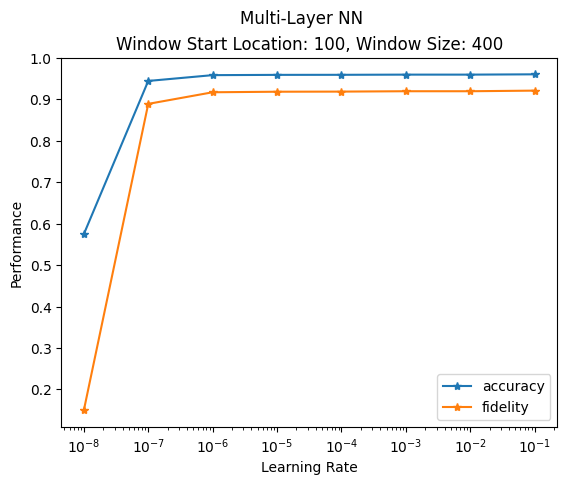

In [14]:
plt.figure()
plt.plot(learning_rates, all_accuracy, '-*', label='accuracy')
plt.plot(learning_rates, np.array(all_accuracy)*2-1, '-*', label='fidelity')
plt.suptitle('Multi-Layer NN')
plt.title(f'Window Start Location: {start_window}, Window Size: {end_window-start_window}')
plt.xlabel('Learning Rate')
plt.ylabel('Performance')
plt.legend()
plt.xscale('log')


In [13]:
for lr, acc in zip(learning_rates, all_accuracy):
    print('Learning Rate:', lr)
    print('    Accuracy:', acc)
    print('    Accuracy:', acc*2-1)


Learning Rate: 0.1
    Accuracy: 0.96065
    Accuracy: 0.9213
Learning Rate: 0.01
    Accuracy: 0.95991
    Accuracy: 0.9198200000000001
Learning Rate: 0.001
    Accuracy: 0.95992
    Accuracy: 0.91984
Learning Rate: 0.0001
    Accuracy: 0.95947
    Accuracy: 0.9189400000000001
Learning Rate: 1e-05
    Accuracy: 0.95933
    Accuracy: 0.91866
Learning Rate: 1e-06
    Accuracy: 0.95867
    Accuracy: 0.91734
Learning Rate: 1.0000000000000001e-07
    Accuracy: 0.94466
    Accuracy: 0.8893200000000001
Learning Rate: 1e-08
    Accuracy: 0.57486
    Accuracy: 0.14972000000000008
